## Currently this notebook is an illustration for Adonis.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from qiskit import ClassicalRegister
from iqm.qiskit_iqm.fake_backends.fake_adonis import IQMFakeAdonis
from iqm.benchmarks.entanglement.graph_states import generate_graph_state
from iqm.benchmarks.shadow_utils import *
from qiskit import ClassicalRegister, transpile
from iqm.qiskit_iqm.iqm_transpilation import optimize_single_qubit_gates
from rustworkx.visualization import mpl_draw
from rustworkx import spring_layout

/opt/anaconda3/envs/iqm-benchmarks/lib/python3.11/site-packages/iqm/iqm_client/iqm_client.py:132: UserWarning: Your IQM Client version 20.9 was built for a different version of IQM Server. You might encounter issues. For the best experience, consider using a version of IQM Client that satisfies 18.0 <= iqm-client < 19.0.
  warnings.warn(version_incompatibility_msg)


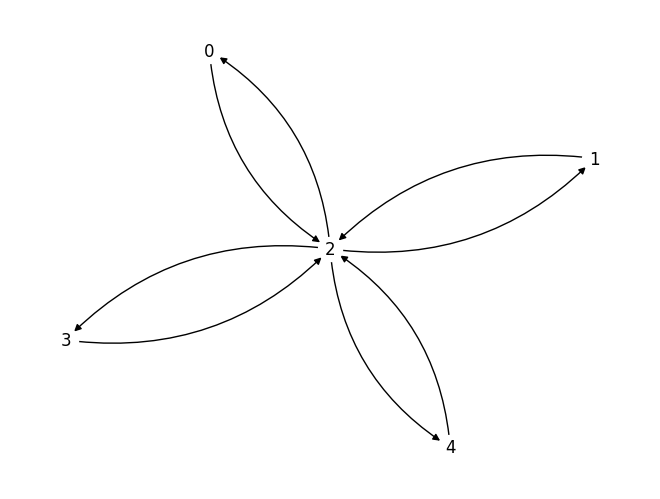

In [2]:
## initiate the backend
import os
from iqm.qiskit_iqm import IQMProvider
os.environ["IQM_TOKEN"] = "fwBucKQFFBYvcynSpatCvgEEEt0faj4RVc7P45XtXUMGdgTJ0WV9L4AAMQzHVeFl"
QPU = 'pyrite'
#iqm_server_url = "https://pluto.mx05.iqm.fi/cocos"

if QPU == 'aphrodite':
    iqm_server_url = "https://fqcp3-host1.xld09.iqm.fi/cocos"
    provider = IQMProvider(iqm_server_url)
    backend = provider.get_backend()
    layout = [1,5,4,6,11]
    reduced_coupling_map = backend.coupling_map.reduce(mapping=layout)
    sub_system = list(reduced_coupling_map)
else:
    iqm_server_url = 'https://cocos.resonance.meetiqm.com/' + QPU
    provider = IQMProvider(iqm_server_url)
    backend = provider.get_backend()
    layout = [0,2,1,3,4]
    sub_system = list(backend.coupling_map)

#backend = IQMFakeAdonis()
mpl_draw(backend.coupling_map.graph, arrows=True, with_labels=True, node_color='w', pos=spring_layout(backend.coupling_map.graph, num_iter=200))

In [3]:
num_qubits = 5
qc = generate_graph_state(list(range(num_qubits)), backend=backend)

sub_system = [v for i, v in enumerate(sub_system) if i % 2 == 0]
sub_system = [list(x) for x in sub_system]

groups = [list(set(list(range(num_qubits))) - set(x)) for x in sub_system]
num_group = len(groups)
## given the quantum circuit, the neighbouring qubits are measured in the z basis
## For Adnois this forms 4 such groups.
def project_neighbouring_qubits(qc, num_cregs, meas_qubit):
    qc_copy = qc.copy()
    qc_copy.barrier()
    register = ClassicalRegister(num_cregs)
    qc_copy.add_register(register)
    for idx, iq in enumerate(meas_qubit):
        qc_copy.measure(iq, register[idx])
    return qc_copy

neighbour_qubits = 3
qc_list = [project_neighbouring_qubits(qc, neighbour_qubits, x) for x in groups]

In [4]:
Nu = 200 ## number of random unitaries used
Nm = 1000 ## number of measurements per random unitary
counts_list = []
unitaries_list = []
for circs in qc_list:
    unitaries, rm_circs = haar_shadow_tomography(circs, Nu, list(range(num_qubits)))
    rm_trans = [optimize_single_qubit_gates(transpile(qcc, backend, initial_layout=layout), drop_final_rz=True) for qcc in rm_circs]

    job = backend.run(rm_trans, shots = Nm)  
    counts = job.result().get_counts()
    counts_list.append(counts)
    unitaries_list.append(unitaries)

In [5]:
neigbour_bit_strings = [' ' + format(x, '0'+str(neighbour_qubits)+'b') for x in range(2**neighbour_qubits)] # list of strings of the remaining 3 neighbouring qubits
counts_bit = [] ## counts of the edge of interest in the graph for all possible combination of the neighbouring qubits

for ibit in neigbour_bit_strings:
    counts_group = []
    for iu in range(len(groups)):
        counts_per_batch = []
        for iq in range(len(counts_list[iu])):
            counts_new = {}
            for inm, ist in enumerate(counts_list[iu][iq].keys()):
                if (ist[-4:] == ibit):
                    counts_new[ist[0:5]] = counts_list[iu][iq][ist]
            counts_per_batch.append(counts_new)
        counts_group.append(counts_per_batch)
    counts_bit.append(counts_group)

In [6]:
## construct shadows for each neighbour_bit_string and each edge of interest.
rho_shadows_all_bits = []

for idx, ibit in enumerate(neigbour_bit_strings):
    rho_shadows = []
    for ib in range(len(groups)):
        nqubits = len(sub_system[ib])
        rho = np.zeros((2**nqubits, 2**nqubits), dtype = complex)
        for iu in range(Nu):
            rho += get_shadow(counts_bit[idx][ib][iu], unitaries_list[ib][iu,:,:,:], sub_system[ib])/Nu
        rho_shadows.append(rho)
    rho_shadows_all_bits.append(rho_shadows)

Text(0.5, 0, 'Edges')

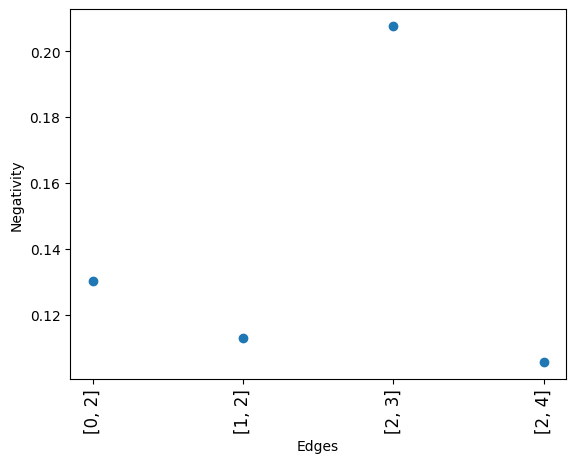

In [7]:
## compute the 2 qubit negativity for each of the neighbour bitstrings and groups
neg = [[np.abs(get_negativity(rho_shadows_all_bits[bits][isys], 1, 1)) for bits in range(2**neighbour_qubits)] for isys in range(num_group)]
neg_per_edge = [max(x) for x in neg]
get_index = [x.index(max(x)) for x in neg]
max_neg_dm = [rho_shadows_all_bits[get_index[x]][x] for x in range(num_group)]

## plot negativity
plt.scatter(list(range(num_group)), neg_per_edge)
plt.xticks(list(range(num_group)), sub_system, fontsize=12, rotation=90)
plt.ylabel('Negativity')
plt.xlabel('Edges')

/var/folders/9q/gfn_q0d140j6zndhjdcz8gdm0000gq/T/ipykernel_96665/3169750565.py:43: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


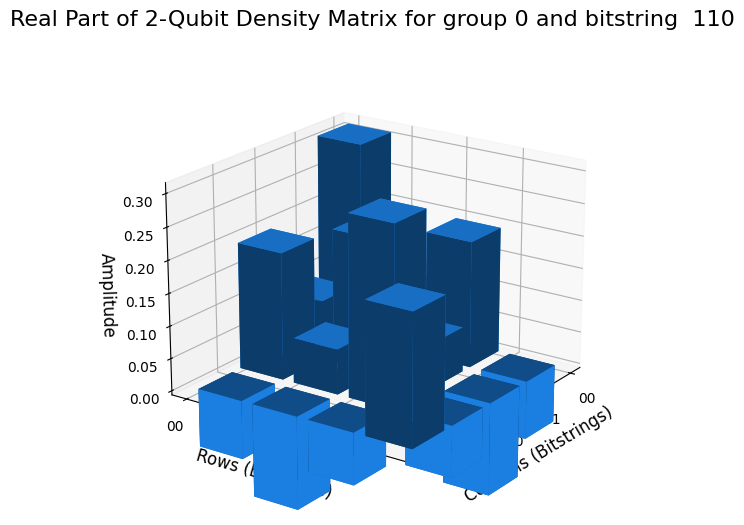

/var/folders/9q/gfn_q0d140j6zndhjdcz8gdm0000gq/T/ipykernel_96665/3169750565.py:43: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


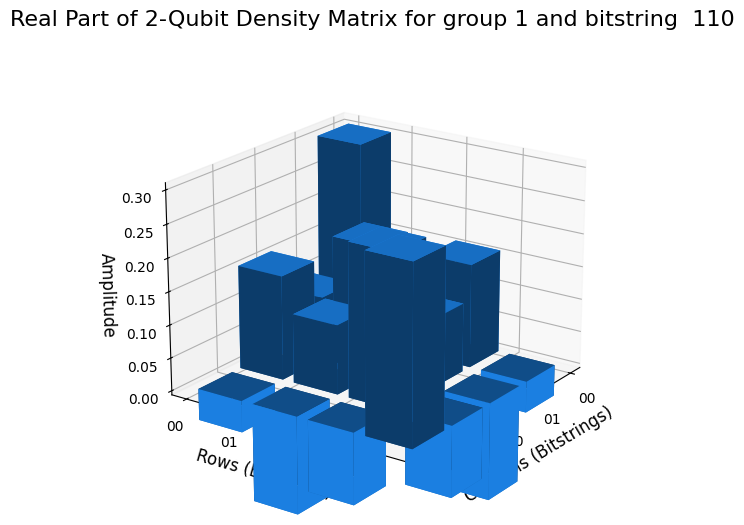

/var/folders/9q/gfn_q0d140j6zndhjdcz8gdm0000gq/T/ipykernel_96665/3169750565.py:43: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


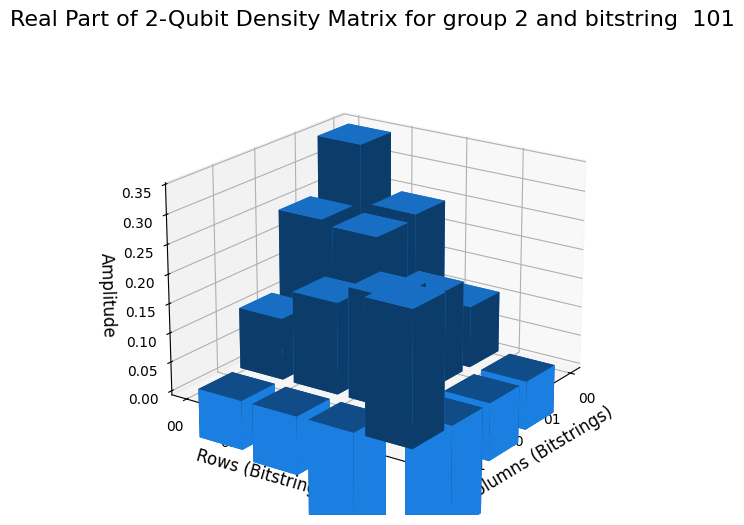

/var/folders/9q/gfn_q0d140j6zndhjdcz8gdm0000gq/T/ipykernel_96665/3169750565.py:43: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


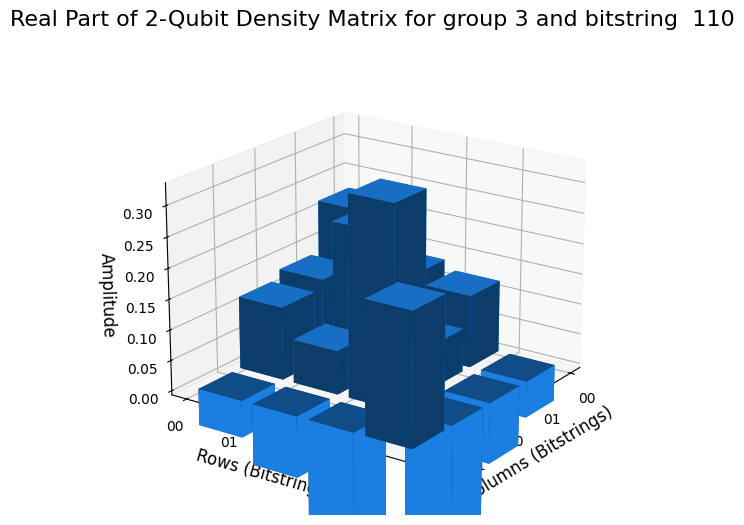

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Bitstring labels for 2-qubit states
bitstrings = ['00', '01', '10', '11']

# Function to create 3D bar plot
def plot_tomography(matrix, title, color):
    n = matrix.shape[0]
    xpos, ypos = np.meshgrid(np.arange(n), np.arange(n), indexing="ij")
    xpos, ypos = xpos.flatten(), ypos.flatten()
    zpos = np.zeros_like(xpos)

    # Heights of the bars (matrix elements)
    heights = matrix.flatten()

    # Bar dimensions
    dx = dy = 0.8

    # Create the figure
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')

    # Plot the bars
    ax.bar3d(xpos, ypos, zpos, dx, dy, heights, shade=True, color=color)

    # Set axis labels with bitstrings
    ax.set_xticks(np.arange(n))
    ax.set_yticks(np.arange(n))
    ax.set_xticklabels(bitstrings, fontsize=10)
    ax.set_yticklabels(bitstrings, fontsize=10)

    # Add title and axis labels
    ax.set_title(title, fontsize=16, pad=20)
    ax.set_xlabel("Columns (Bitstrings)", fontsize=12)
    ax.set_ylabel("Rows (Bitstrings)", fontsize=12)
    ax.set_zlabel("Amplitude", fontsize=12)

    # Set the view angle for better visualization
    ax.view_init(elev=20, azim=35)

    # Show the plot
    plt.tight_layout()
    plt.show()

# Plot the real part in blue
for iq in range(num_group):
    plot_tomography(np.real(max_neg_dm[iq]), f"Real Part of 2-Qubit Density Matrix for group {iq} and bitstring {neigbour_bit_strings[get_index[iq]]}", color="dodgerblue")

